# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

# TASK #2: IMPORT LIBRARIES AND DATASET

In [ ]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify training data directory
X_Ray = '/content/drive/MyDrive/Data Science for Business Package/4. Operations Department/Dataset'

In [ ]:
# List the folders in the directory
os.listdir(X_Ray)

['0', '3', '2', '1']

In [ ]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(X_Ray, target_size=(256, 256), class_mode='categorical', batch_size=40, shuffle=True, subset='training')


Found 428 images belonging to 4 classes.


In [ ]:
validation_generator = image_generator.flow_from_directory(X_Ray, class_mode='categorical', target_size=(256, 256), subset='validation', batch_size=40)

Found 104 images belonging to 4 classes.


In [ ]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]],

In [ ]:
# labels Translator 
label_names = {0: 'COVID-19', 1: 'Healthy', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

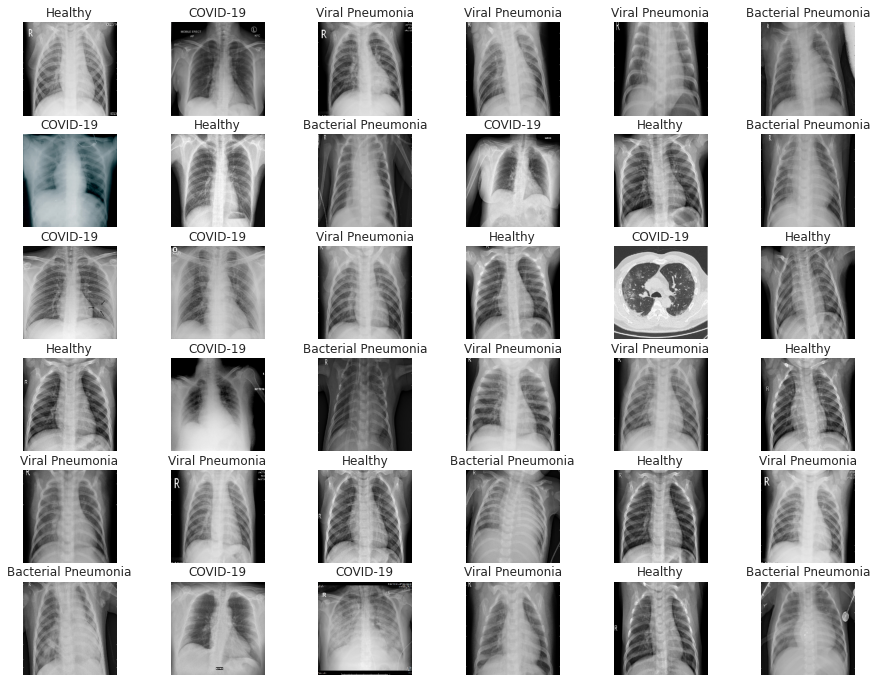

In [ ]:
sns.set_theme(style='ticks')
L = 6
W = 6

fig, ax = plt.subplots(L, W, figsize=(15, 12))
ax = ax.ravel()

for i in np.arange(0, L*W):
  ax[i].imshow(train_images[i])
  ax[i].set_title(label_names[np.argmax(train_labels[i])])
  ax[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [ ]:
basemodel = ResNet50(include_top = False, weights = 'imagenet', input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(units=256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(units=128, activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(units=4, activation='softmax')(headmodel)

In [ ]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', patience = 20, mode='min')
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(directory=X_Ray, target_size=(256, 256), class_mode='categorical', batch_size=4, shuffle=True, subset='training')

Found 428 images belonging to 4 classes.


In [ ]:
val_generator = image_generator.flow_from_directory(directory=X_Ray, target_size=(256, 256), class_mode='categorical', batch_size=4, shuffle=True, subset='validation')

Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4 validation_data=val_generator, validation_steps=val_generator.n//4 epochs=50, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
107/107 [==============================] - 162s 1s/step - loss: 1.1246 - accuracy: 0.6002 - val_loss: 1.6795 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.67947, saving model to weights.hdf5
Epoch 2/50
107/107 [==============================] - 13s 118ms/step - loss: 0.4057 - accuracy: 0.8422 - val_loss: 6.8896 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 1.67947
Epoch 3/50
107/107 [==============================] - 13s 119ms/step - loss: 0.2148 - accuracy: 0.9516 - val_loss: 8.3117 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 1.67947
Epoch 4/50
107/107 [==============================] - 13s 120ms/step - loss: 0.2756 - accuracy: 0.9262 - val_loss: 8.4289 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 1.67947
Epoch 5/50
107/107 [==============================] - 13s 121ms/step - loss: 0.2442 - accuracy: 0.9384 - val_loss: 4.2764 - val_accuracy: 0.2981

Epoch 00005: val_loss did not improve 

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

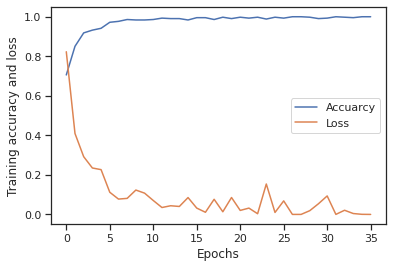

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['Accuarcy', 'Loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')
plt.show()

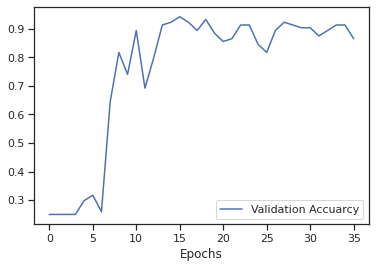

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.legend(['Validation Accuarcy'])
plt.xlabel('Epochs')
# plt.ylabel('Training accuracy and loss')
plt.show()

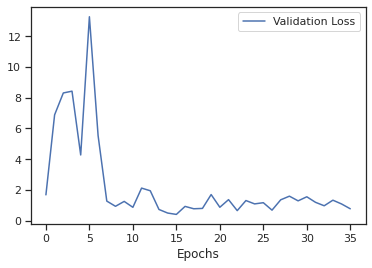

In [ ]:
plt.plot(history.history['val_loss'])
plt.legend(['Validation Loss'])
plt.xlabel('Epochs')
# plt.ylabel('Training accuracy and loss')
plt.show()

In [ ]:
test_directory = '/content/drive/MyDrive/Data Science for Business Package/4. Operations Department/Test'

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_gen.flow_from_directory(directory=test_directory, target_size=(256, 256), class_mode='categorical', batch_size=4, shuffle=True)

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator, steps=test_generator.n//4, verbose=1)
print(f'Accuracy = {evaluate[1]}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


10/10 [==============================] - 1s 75ms/step - loss: 2.5821 - accuracy: 0.7750
Accuracy = 0.7749999761581421


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.75


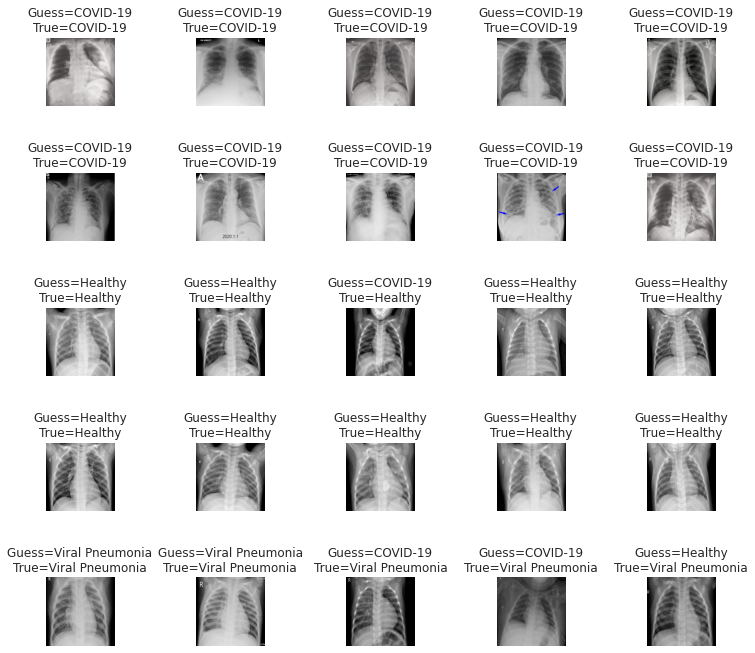

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 